In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetect
import lsst.meas.algorithms as measAlgo
from lsst.meas.algorithms.detection import SourceDetectionTask
from toolbox.image import zscale
plt.style.use('jpg')

def smooth_image(maskedImage, sigma):
    kWidth = (int(sigma * 7 + 0.5) // 2) * 2 + 1 # make sure it is odd
    gaussFunc = afwMath.GaussianFunction1D(sigma)
    gaussKernel = afwMath.SeparableKernel(kWidth, kWidth, gaussFunc, gaussFunc)
    convolvedImage = maskedImage.Factory(maskedImage.getBBox())
    afwMath.convolve(convolvedImage, maskedImage, gaussKernel, afwMath.ConvolutionControl())
    return convolvedImage

In [2]:
data_dir = os.environ.get('LOCAL_DATA')
fn = os.path.join(data_dir, 'calexp-HSC-I-9348-7,6.fits')
exposure = afwImage.ExposureF(fn)
disp  = afwDisplay.Display(1)
mi = exposure.getMaskedImage()
mask = mi.getMask()
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
afwImage.MaskU.addMaskPlane('THRESH_HI');

In [3]:
psf = exposure.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
ngrow = int(2.4*sigma + 0.5)
mi_smooth = smooth_image(mi, sigma)

## High threshold detection

In [4]:
hi_val = 9.0
thresh_hi = afwDetect.Threshold(hi_val, afwDetect.Threshold.STDEV)
fp_hi = afwDetect.FootprintSet(mi_smooth, thresh_hi)
fp_hi = afwDetect.FootprintSet(fp_hi, ngrow, True)

## Low threshold detection

In [5]:
lo_val = 1.2
thresh_lo = afwDetect.Threshold(lo_val, afwDetect.Threshold.STDEV)
fp_lo = afwDetect.FootprintSet(mi_smooth, thresh_lo, 'img', 50)
fp_lo = afwDetect.FootprintSet(fp_lo, ngrow)

## Set masks and generate noise array

In [6]:
mask.clearMaskPlane(mask.getMaskPlane('THRESH_HI'))
mask.clearMaskPlane(mask.getMaskPlane('DETECTED'))
fp_hi.setMask(mask, 'THRESH_HI')
fp_lo.setMask(mask, 'DETECTED')
back_rms = mi.getImage().getArray()[mask.getArray()==0].std()
noise_array = back_rms*np.random.randn(mask.getArray().shape[0], mask.getArray().shape[1])
print('bacground rms =', back_rms)

bacground rms = 0.0554344


## Visualize segmentation maps

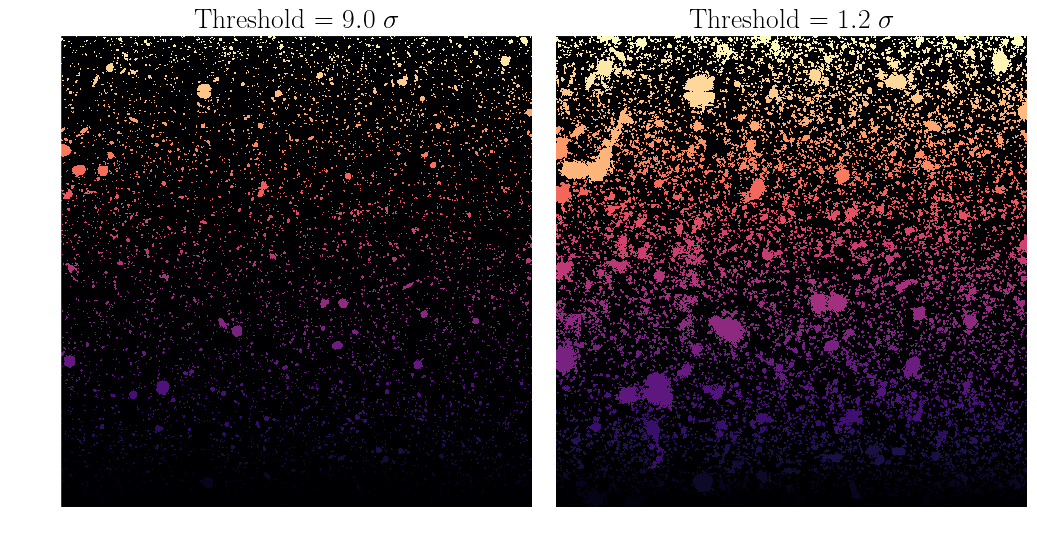

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)
seg_hi = fp_hi.insertIntoImage(True).getArray()
seg_lo = fp_lo.insertIntoImage(True).getArray()
titles = ['Threshold = $'+str(hi_val)+'\ \sigma$', 
          'Threshold = $'+str(lo_val)+'\ \sigma$']
for i, (title, seg) in enumerate(zip(titles, [seg_hi, seg_lo])):
    ax[i].imshow(seg, origin='low', cmap=plt.cm.magma, aspect='equal')
    ax[i].set_axis_off()
    ax[i].set_title(title, fontsize=20)            

## View with ds9

In [8]:
disp.setMaskPlaneColor('THRESH_HI', 'red')
disp.setMaskPlaneColor('DETECTED', 'blue')
disp.setMaskTransparency(75)
disp.mtv(exposure)

## Replace objects with noise

In [9]:
mi_clone = mi.clone()
mi_clone.getImage().getArray()[seg_lo!=0] = noise_array[seg_lo!=0]

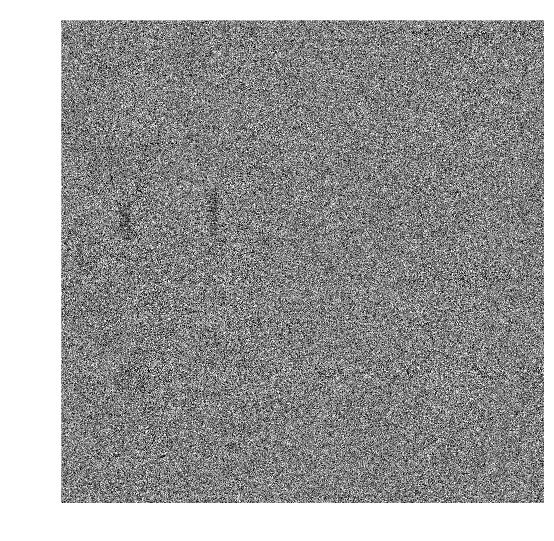

In [10]:
plt.figure(figsize=(6,6))
vmin, vmax = zscale(mi_clone.getImage().getArray())
plt.imshow(mi_clone.getImage().getArray(), vmin=vmin, 
           vmax=vmax, cmap=plt.cm.gray, aspect='equal')
plt.axis('off');